# Problema

Predecir el coste del seguro

## Instrucciones

 Utilizar el dataset (insurance.csv) para entrenar un modelo de regresión capaz de predecir el valor del seguro en función de las características del cliente. Realizar limpieza, preprocesado modelado y testeo del modelo aportando conclusiones de todos estos pasos.

# El set de datos

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance



In [71]:
# imports
import pandas as pd

In [72]:
ruta = "insurance.csv"
data = pd.read_csv(ruta)

In [73]:
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Objetivo

Generar un model de regresión capaz de predecir el valor del seguro en base a las características del cliente.

* Aplicar las técnicas oportunas de procesamiento de datos (lipieza, nans, escalado...)

* Valorar diferentes modelos de regresión (linear regressor, polynomial, ridge, lasso, elastic, decission tree y random forest)

* Comparación entre modelos (dividir el dataset en train y test, entrenar con el train y evaluar con el test)

* Métricas (todas, y que aporta cada una)

* Conclusiones finales

# Implementación

## Limpieza de datos

### Eliminación de nulos

In [74]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No hay nulos

### Eliminación de duplicados

In [75]:
data.duplicated().sum()

np.int64(1)

In [76]:
data = data.drop_duplicates()

In [77]:
data.duplicated().sum()

np.int64(0)

### Tranformación de los datos

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


#### Age

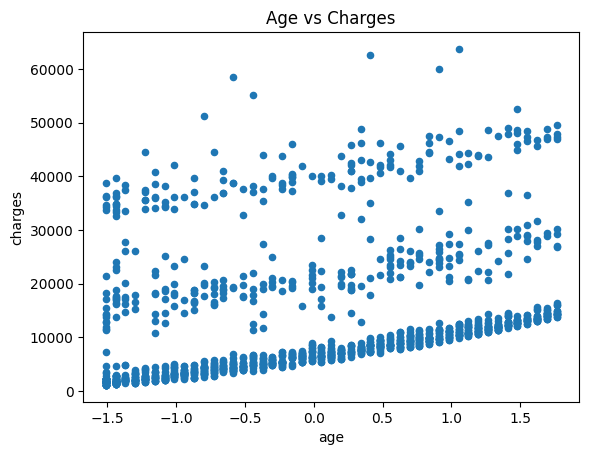

In [133]:
plot = data.plot(kind='scatter', x='age', y='charges', title='Age vs Charges')

#### Sex

In [79]:
data["sex"].value_counts()

sex
male      675
female    662
Name: count, dtype: int64

In [80]:
# one hot encoding sex
data = pd.get_dummies(data, columns=["sex"])

#### Smoker

In [81]:
data["smoker"].value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

In [82]:
data = pd.get_dummies(data, columns=["smoker"])

#### Region

In [ ]:
data["region"].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

In [84]:
data = pd.get_dummies(data, columns=["region"])

---

Pasamos de true false a 1 y 0

In [85]:
for col in data.columns:
    if data[col].dtype == "bool":
        data[col] = data[col].astype(int)

In [86]:
data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


### Normalización

In [87]:
# Normalizamos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

charges = data["charges"].reset_index(drop=True) # Reseteamos el índice
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns).reset_index(drop=True)
data["charges"] = charges

In [88]:
data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,16884.92400,1.009771,-1.009771,-1.969660,1.969660,-0.565546,-0.565546,-0.611638,1.764609
1,-1.511647,0.509422,-0.079442,1725.55230,-0.990324,0.990324,0.507702,-0.507702,-0.565546,-0.565546,1.634955,-0.566698
2,-0.799350,0.383155,1.580143,4449.46200,-0.990324,0.990324,0.507702,-0.507702,-0.565546,-0.565546,1.634955,-0.566698
3,-0.443201,-1.305052,-0.909234,21984.47061,-0.990324,0.990324,0.507702,-0.507702,-0.565546,1.768203,-0.611638,-0.566698
4,-0.514431,-0.292456,-0.909234,3866.85520,-0.990324,0.990324,0.507702,-0.507702,-0.565546,1.768203,-0.611638,-0.566698


## Modelado

### Training

In [89]:
X = data.drop("charges", axis=1)
y = data["charges"]

In [90]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

linear regressor, polynomial, ridge, lasso, elastic, decission tree y random forest

In [96]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

#### Linear Regressor

In [94]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_r2_train = lr_model.score(X_train, y_train)
lr_r2_val = lr_model.score(X_val, y_val)
print(f"R2 Linear Regression Train: {lr_r2_train}")
print(f"R2 Linear Regression Val: {lr_r2_val}")

R2 Linear Regression Train: 0.7315026287772068
R2 Linear Regression Val: 0.72110362715151


####  Polynomial

In [99]:
poly2 = PolynomialFeatures(degree=2)

X_train_poly2 = poly2.fit_transform(X_train)
X_val_poly2 = poly2.transform(X_val)
X_test_poly2 = poly2.transform(X_test)

poly2_lr_model = LinearRegression()
poly2_lr_model.fit(X_train_poly2, y_train)

poly2_r2_train = poly2_lr_model.score(X_train_poly2, y_train)
poly2_r2_val = poly2_lr_model.score(X_val_poly2, y_val)
print(f"R2 Polynomial Regression Train: {poly2_r2_train}")
print(f"R2 Polynomial Regression Val: {poly2_r2_val}")

R2 Polynomial Regression Train: 0.8439340155884468
R2 Polynomial Regression Val: 0.787960839276975


In [100]:

poly_3 = PolynomialFeatures(degree=3)

X_train_poly3 = poly_3.fit_transform(X_train)
X_val_poly3 = poly_3.transform(X_val)
X_test_poly3 = poly_3.transform(X_test)

poly3_lr_model = LinearRegression()
poly3_lr_model.fit(X_train_poly3, y_train)

poly3_r2_train = poly3_lr_model.score(X_train_poly3, y_train)
poly3_r2_val = poly3_lr_model.score(X_val_poly3, y_val)
print(f"R2 Polynomial Regression Train: {poly3_r2_train}")
print(f"R2 Polynomial Regression Val: {poly3_r2_val}")

R2 Polynomial Regression Train: 0.8610384599782055
R2 Polynomial Regression Val: 0.7698946452547403


#### Ridge

In [101]:
riedge_model = Ridge(alpha=0.5)
riedge_model.fit(X_train, y_train)

ridge_r2_train = riedge_model.score(X_train, y_train)
ridge_r2_val = riedge_model.score(X_val, y_val)
print(f"R2 Ridge Regression Train: {ridge_r2_train}")
print(f"R2 Ridge Regression Val: {ridge_r2_val}")

R2 Ridge Regression Train: 0.7315025235707087
R2 Ridge Regression Val: 0.721098522004405


#### Lasso

In [103]:
lasso_model = Lasso(alpha=0.5)
lasso_model.fit(X_train, y_train)

lasso_r2_train = lasso_model.score(X_train, y_train)
lasso_r2_val = lasso_model.score(X_val, y_val)
print(f"R2 Lasso Regression Train: {lasso_r2_train}")
print(f"R2 Lasso Regression Val: {lasso_r2_val}")

R2 Lasso Regression Train: 0.731502613079545
R2 Lasso Regression Val: 0.7211038066263044


#### Elastic Net

In [104]:
elastic_model = ElasticNet(alpha=0.5, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)

elastic_r2_train = elastic_model.score(X_train, y_train)
elastic_r2_val = elastic_model.score(X_val, y_val)
print(f"R2 ElasticNet Regression Train: {elastic_r2_train}")
print(f"R2 ElasticNet Regression Val: {elastic_r2_val}")

R2 ElasticNet Regression Train: 0.7193317398384036
R2 ElasticNet Regression Val: 0.7064385067042849


#### Decission Tree

In [105]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

dt_r2_train = dt_model.score(X_train, y_train)
dt_r2_val = dt_model.score(X_val, y_val)
print(f"R2 Decision Tree Regression Train: {dt_r2_train}")
print(f"R2 Decision Tree Regression Val: {dt_r2_val}")

R2 Decision Tree Regression Train: 1.0
R2 Decision Tree Regression Val: 0.5874837821010891


#### Random Fores

In [106]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

rf_r2_train = rf_model.score(X_train, y_train)
rf_r2_val = rf_model.score(X_val, y_val)
print(f"R2 Random Forest Regression Train: {rf_r2_train}")
print(f"R2 Random Forest Regression Val: {rf_r2_val}")

R2 Random Forest Regression Train: 0.9766228474856835
R2 Random Forest Regression Val: 0.7801811865784648


### Testing

In [130]:
lr_r2_test = lr_model.score(X_test, y_test)
print(f"R2 Linear Regression Test: {lr_r2_test}")

poly2_r2_test = poly2_lr_model.score(X_test_poly2, y_test)
print(f"R2 Polynomial Regression Degree 2 Test: {poly2_r2_test}")
poly3_r2_test = poly3_lr_model.score(X_test_poly3, y_test)
print(f"R2 Polynomial Regression Degree 3 Test: {poly3_r2_test}")

ridge_r2_test = riedge_model.score(X_test, y_test)
print(f"R2 Ridge Regression Test: {ridge_r2_test}")

lasso_r2_test = lasso_model.score(X_test, y_test)
print(f"R2 Lasso Regression Test: {lasso_r2_test}")

elastic_r2_test = elastic_model.score(X_test, y_test)
print(f"R2 ElasticNet Regression Test: {elastic_r2_test}")

dt_r2_test = dt_model.score(X_test, y_test)
print(f"R2 Decision Tree Regression Test: {dt_r2_test}")

rf_r2_test = rf_model.score(X_test, y_test)
print(f"R2 Random Forest Regression Test: {rf_r2_test}")

R2 Linear Regression Test: 0.8057067181435495
R2 Polynomial Regression Degree 2 Test: 0.8790492307187359
R2 Polynomial Regression Degree 3 Test: 0.854459322792374
R2 Ridge Regression Test: 0.8056338006054696
R2 Lasso Regression Test: 0.8056935113363698
R2 ElasticNet Regression Test: 0.7701451469535062
R2 Decision Tree Regression Test: 0.8017779336725195
R2 Random Forest Regression Test: 0.8794241207060087


# Conclusiones

A continuación pasaremos a comentar los resultados obtenidos:

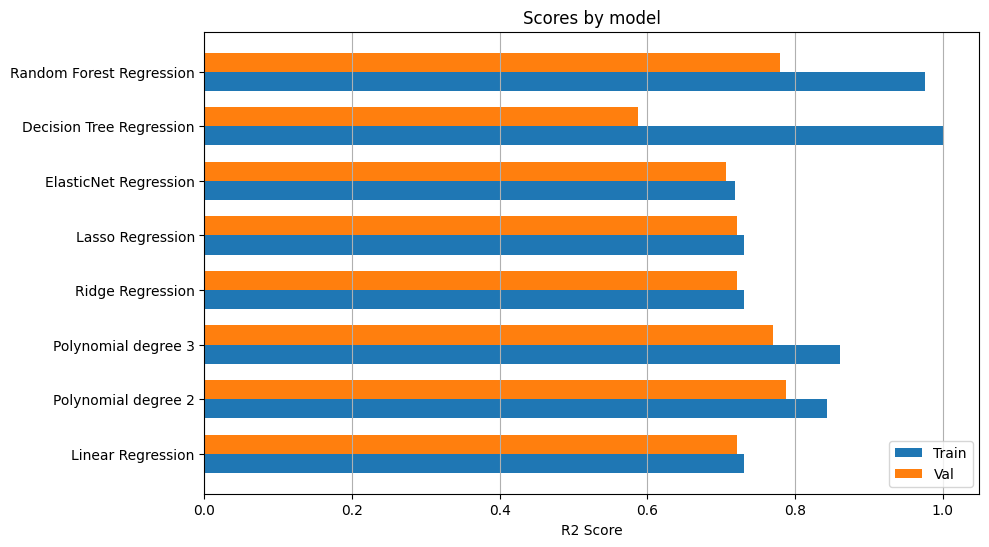

In [110]:
# plot all scores
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear Regression", "Polynomial degree 2", "Polynomial degree 3", 
          "Ridge Regression", "Lasso Regression", "ElasticNet Regression", 
          "Decision Tree Regression", "Random Forest Regression"]
scores = [lr_r2_train, poly2_r2_train, poly3_r2_train, 
          ridge_r2_train, lasso_r2_train, elastic_r2_train, 
          dt_r2_train, rf_r2_train]
scores_val = [lr_r2_val, poly2_r2_val, poly3_r2_val, 
              ridge_r2_val, lasso_r2_val, elastic_r2_val, 
              dt_r2_val, rf_r2_val]

y = np.arange(len(models))  # the label locations
height = 0.35  # the height of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bars (from left to right)
rects1 = ax.barh(y - height/2, scores, height, label="Train")
rects2 = ax.barh(y + height/2, scores_val, height, label="Val")

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_xlabel("R2 Score")
ax.set_title("Scores by model")
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.legend()
ax.grid(axis="x")

# Display the plot
plt.show()


Como se puede apreciar en la gráfica anterior anterior, el modelo que consigue una mayor puntuacion en validacion es el `Polynomial Regresor` de grado 2 el cual se encuentra muy empatado con el `Random Forest Regressor`.

Una cuestion apreciable en la gráfica la cual es destacable son las altas puntuaciones obtenidas en
los modelos de `Random Forest Regressor` y `Decision Tree Regressor` en comparación con los demás modelos. Esto puede deberse a que estos modelos son capaces de capturar relaciones complejas entre las variables pero al tratarse de un dataset pequeño, se estan sobreajustan a los datos de entrenamiento.

---

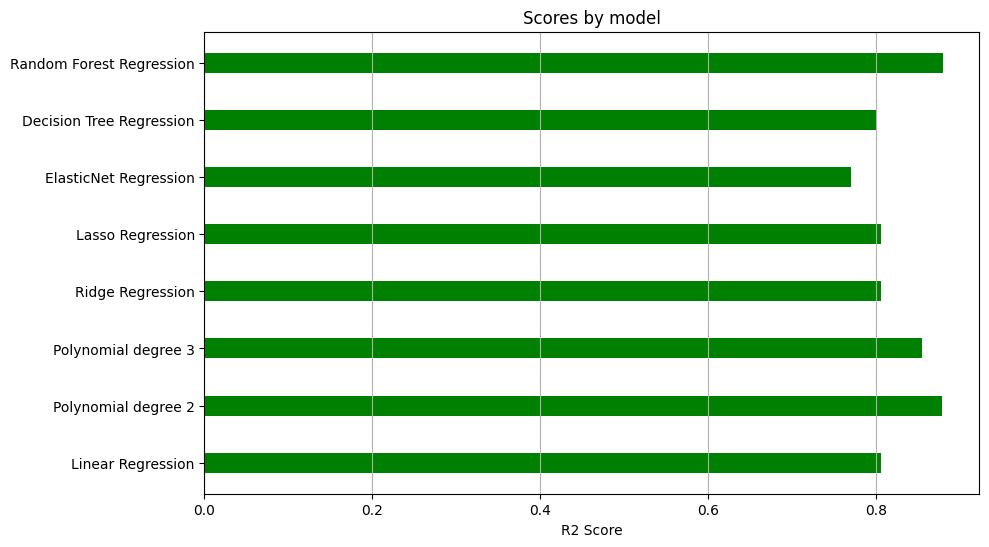

In [ ]:
models = ["Linear Regression", "Polynomial degree 2", "Polynomial degree 3", 
          "Ridge Regression", "Lasso Regression", "ElasticNet Regression", 
          "Decision Tree Regression", "Random Forest Regression"]
scores = [lr_r2_test, poly2_r2_test, poly3_r2_test,
          ridge_r2_test, lasso_r2_test, elastic_r2_test,
          dt_r2_test, rf_r2_test]

y = np.arange(len(models))  # the label locations
height = 0.35  # the height of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bars (from left to right)
rects1 = ax.barh(y, scores, height, label="Test", color="green")

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_xlabel("R2 Score")
ax.set_title("Scores by model")
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.grid(axis="x")

# Display the plot
plt.show()

Analizando las puntuaciones en testing, observamos que la situación es muy similar a la validación, lo que sugiere que los modelos generalizan bien y no han sufrido sobreajuste significativo.

Las mejores puntuaciones son las siguientes:

1. `Random Forest Regressor`: 0.8794
2. `Polynomial Regression (Degree 2)`: 0.8790
3. `Polynomial Regression (Degree 3)`: 0.8545

El mejor rendimiento lo obtiene el `Random Forest Regressor`, lo que indica que la combinación de múltiples árboles de decisión ayuda a capturar relaciones complejas en los datos sin comprometer la capacidad de generalización.

Las regresiones polinómicas (grado 2 y 3) también muestran un desempeño competitivo, con el modelo de grado 2 casi igualando a Random Forest. Esto sugiere que la relación entre las variables tiene un componente polinómico fuerte, pero sin llegar a necesitar un grado 3, ya que este último muestra una ligera caída en rendimiento, lo que podría indicar un leve sobreajuste.

La alta puntuación de modelos más simples (como la regresión lineal) sugiere que el problema analizado no es excesivamente complejo.